# Inspector tutorial

#### What is inspector ?  
   Vai_q_pytorch provides a function called inspector to help users diagnose neural network (NN) models under different device architectures. The inspector can predict target device assignments based on hardware constraints.The generated inspection report can be used to guide  users to modify or optimize the NN model, greatly reducing the difficulty and time of deployment. It is recommended to inspect float models before quantization.

In [1]:
import torch

In [2]:
# Import inspector API
# 
# Note:
# You can ignore warning message related with XIR. 
# The inspector relies on 'vai_utf' package. In conda env vitis-ai-pytorch in Vitis-AI docker, vai_utf is ready. But if vai_q_pytorch is installed by source code, it needs to install vai_utf in advance.
from pytorch_nndct.apis import Inspector


[VAIQ_NOTE]: Loading NNDCT kernels...


In [3]:
# Define a toy neural network
class ToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu = torch.nn.ReLU()
        self.adaptive_avg_pool2d = torch.nn.AdaptiveAvgPool2d(output_size=2)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.adaptive_avg_pool2d(x)
        x = x.reshape(x.size(0), -1)
        return x

In [4]:
# Specify a target name or fingerprint you want to deploy on
target = "DPUCAHX8L_ISA0_SP"
# Initialize inspector with target
inspector = Inspector(target)


[VAIQ_NOTE]: Inspector is on.


In [5]:
# Start to inspect the float model
# Note: visualization of inspection results relies on the dot engine.If you don't install dot successfully, set 'image_format = None' when inspecting.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToyModel()
dummy_input = torch.randn(1, 128, 3, 3)
inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ToyModel...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model ToyModel is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 8/8 [00:00<00:00, 640.93it/s, OpInfo: name = return_0, type = Return]     


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/ToyModel.py)

[VAIQ_WARN]: ToyModel::148 is not tensor.

[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:ToyModel::ToyModel/Conv2d[conv]/input.5, op type:nndct_conv2d, output shape: [1, 6, 6, 128]
node name:ToyModel::ToyModel/ReLU[relu]/input, op type:nndct_relu, output shape: [1, 6, 6, 128]



[VAIQ_NOTE]: =>Successfully convert 'nndct_conv2d_nndct_relu_vULPplwK' to xmodel.(/tmp/nndct_conv2d_nndct_relu_vULPplwK_int.xmodel)

[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:ToyModel::ToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/146_sink_transpose_0, op type:nndct_permute, output shape: [1, 128, 2, 2]



[VAIQ_NOTE]: =>Successfully convert 'nndct_permute_qAUrLkZg' to xmodel.(/tmp/nndct_permute_qAUrLkZg_int.xmodel)

[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:ToyModel::ToyModel/153, op type:nndct_reshape, output shape: [1, 512]



[VAIQ_NOTE]: =>Successful


I1125 12:45:35.764264 116399 compile_pass_manager.cpp:285] [UNILOG][INFO] Compile mode: dpu
I1125 12:45:35.764292 116399 compile_pass_manager.cpp:286] [UNILOG][INFO] Debug mode: null
I1125 12:45:35.764302 116399 compile_pass_manager.cpp:290] [UNILOG][INFO] Target architecture: DPUCAHX8L_ISA0_SP
I1125 12:45:35.764380 116399 compile_pass_manager.cpp:355] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_relu_vULPplwK, with op num: 9
I1125 12:45:35.764386 116399 compile_pass_manager.cpp:368] [UNILOG][INFO] Begin to compile...
I1125 12:45:35.773844 116399 compile_pass_manager.cpp:379] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I1125 12:45:35.773864 116399 compile_pass_manager.cpp:384] [UNILOG][INFO] Compile done.
I1125 12:45:35.783205 116399 compile_pass_manager.cpp:285] [UNILOG][INFO] Compile mode: dpu
I1125 12:45:35.783226 116399 compile_pass_manager.cpp:286] [UNILOG][INFO] Debug mode: null
I1125 12:45:35.783231 116399 compile_pass_manager.cpp:290] [UNILOG][INFO] T


[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCAHX8L_ISA0_SP.png)

[VAIQ_NOTE]: =>Finish inspecting.


##### Inspection result anaysis:
1. In this toy model, there are three operations will be assigned to cpu. The reasons for being allocated to the CPU are shown in the column of hardware constraints.
2. The target device of an input node is determined by its consumer.
3. Here, we found that a special permute operation("ToyModel::ToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/146_sink_transpose_0") is inserted by quantizer. Due to data layout difference between Pytorch('NCHW') and XIR('NHWC'), if quantizer inserts some permutes(which the node message in inspect file will inform us about), these permutes may prevent the entire model from being deployed to the target device. Sometimes, we can cancel out this automatically inserted permute by inserting a permute in the original float model, sometimes, we can't.
4. If you want more details about the inspection, see the inspection report under the output directory you specified.
5. The dot image can help you to analyze inspection result in a more intuitive way. "svg" and "png" format are both supported.


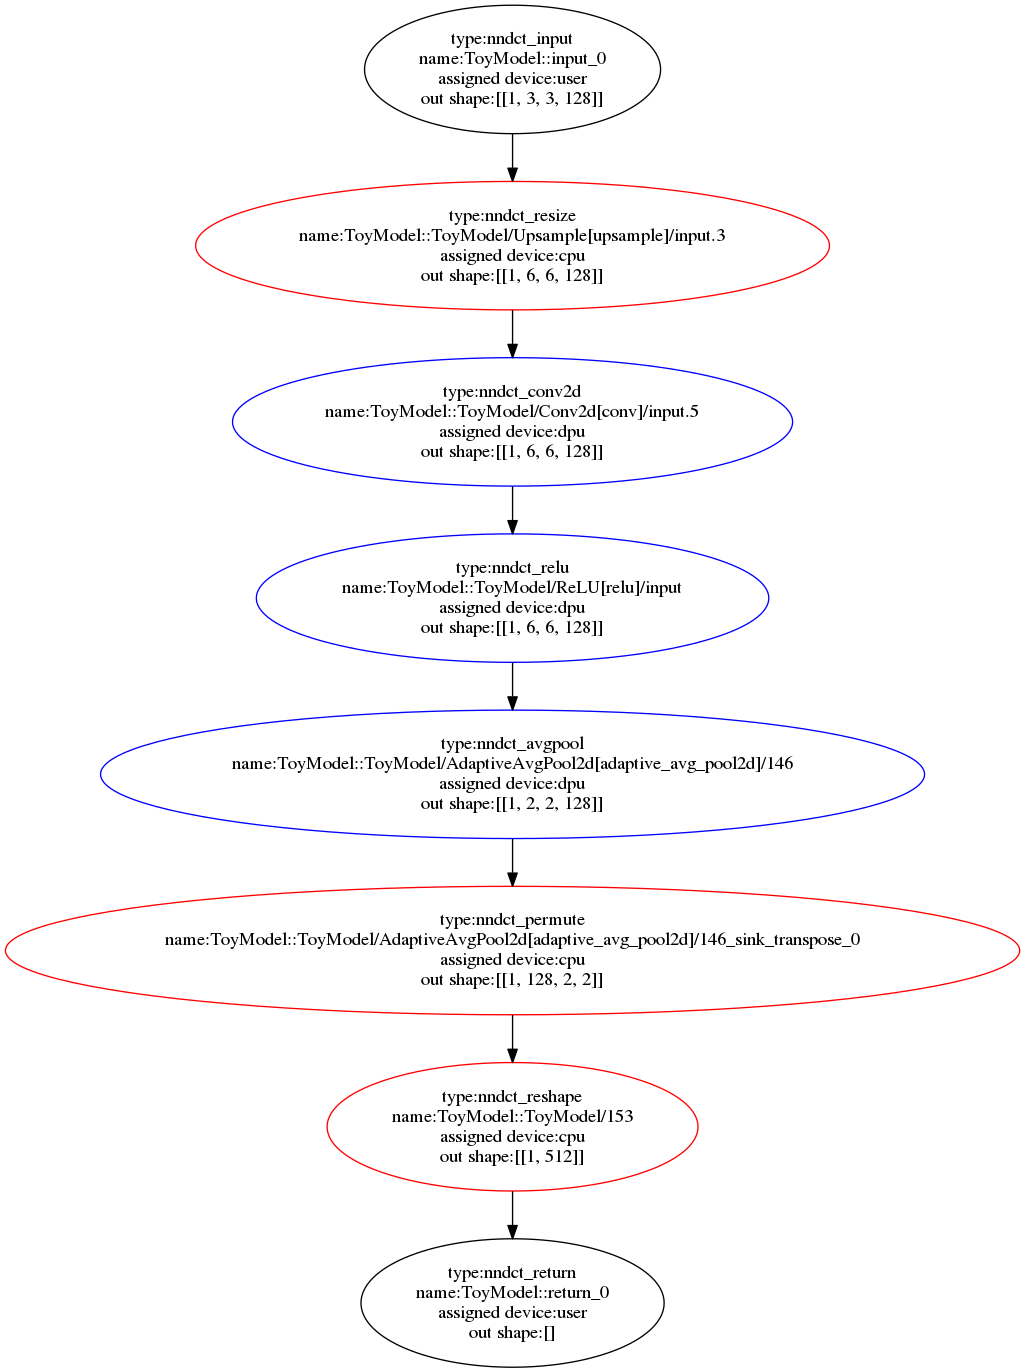

In [6]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCAHX8L_ISA0_SP.png')

##### How to deploy this entire model on DPU:
1. Find the location of CPU operations in original model. All the details of operations are shown in inspect_{target}.txt, including source range, points to a source which is a stack track and helps to find the exact location of this operation in source code. Take resize op as a example, from source range, we can find the location of resize op in #3 input block line 11.  
node name: ToyModel::ToyModel/Upsample[upsample]/input.3  
...  
op type: resize  
...  
source range:  
...  
<font color=red>ipython-input-3-7ec1fc6b678f(11): forward</font>  
...

  

2. Modify the original model according to the hardware constrains message and try to cancel out the permute inserted by quantizer with by inserting a permute in the original float model(more details see hints in inspect_{target}.txt)

In [7]:
# Modified the ToyModel
class ModifiedToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')  # set mode = "nearest"
        self.conv = torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu = torch.nn.ReLU()
        self.adaptive_avg_pool2d = torch.nn.AdaptiveAvgPool2d(output_size=2)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.adaptive_avg_pool2d(x)
        x = x.permute(0, 2, 3, 1) # insert a permute to cancel out the permute inserted by quantizer.
        x = x.reshape(x.size(0), -1)
        return x


In [8]:
# Inspect the modified model
model = ModifiedToyModel()
inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ModifiedToyModel...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model ModifiedToyModel is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 9/9 [00:00<00:00, 1333.69it/s, OpInfo: name = return_0, type = Return]    


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/ModifiedToyModel.py)

[VAIQ_WARN]: ModifiedToyModel::157 is not tensor.

[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:ModifiedToyModel::ModifiedToyModel/Conv2d[conv]/input.5, op type:nndct_conv2d, output shape: [1, 6, 6, 128]
node name:ModifiedToyModel::ModifiedToyModel/ReLU[relu]/input, op type:nndct_relu, output shape: [1, 6, 6, 128]



[VAIQ_NOTE]: =>Successfully convert 'nndct_conv2d_nndct_relu_aCFdmPJj' to xmodel.(/tmp/nndct_conv2d_nndct_relu_aCFdmPJj_int.xmodel)

[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:ModifiedToyModel::ModifiedToyModel/162, op type:nndct_reshape, output shape: [1, 512]



[VAIQ_NOTE]: =>Successfully convert 'nndct_reshape_K2zbMVAS' to xmodel.(/tmp/nndct_reshape_K2zbMVAS_int.xmodel)

[VAIQ_NOTE]: Find subgraph for pool_fix_4:
node name:ModifiedToyModel::ModifiedToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/149, op type:nndct_avgpoo


I1125 12:45:36.132879 116399 compile_pass_manager.cpp:285] [UNILOG][INFO] Compile mode: dpu
I1125 12:45:36.132902 116399 compile_pass_manager.cpp:286] [UNILOG][INFO] Debug mode: null
I1125 12:45:36.132907 116399 compile_pass_manager.cpp:290] [UNILOG][INFO] Target architecture: DPUCAHX8L_ISA0_SP
I1125 12:45:36.133020 116399 compile_pass_manager.cpp:355] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_relu_aCFdmPJj, with op num: 9
I1125 12:45:36.133025 116399 compile_pass_manager.cpp:368] [UNILOG][INFO] Begin to compile...
I1125 12:45:36.143179 116399 compile_pass_manager.cpp:379] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I1125 12:45:36.143201 116399 compile_pass_manager.cpp:384] [UNILOG][INFO] Compile done.
I1125 12:45:36.157305 116399 compile_pass_manager.cpp:285] [UNILOG][INFO] Compile mode: dpu
I1125 12:45:36.157330 116399 compile_pass_manager.cpp:286] [UNILOG][INFO] Debug mode: null
I1125 12:45:36.157341 116399 compile_pass_manager.cpp:290] [UNILOG][INFO] T


[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCAHX8L_ISA0_SP.png)

[VAIQ_NOTE]: =>Finish inspecting.


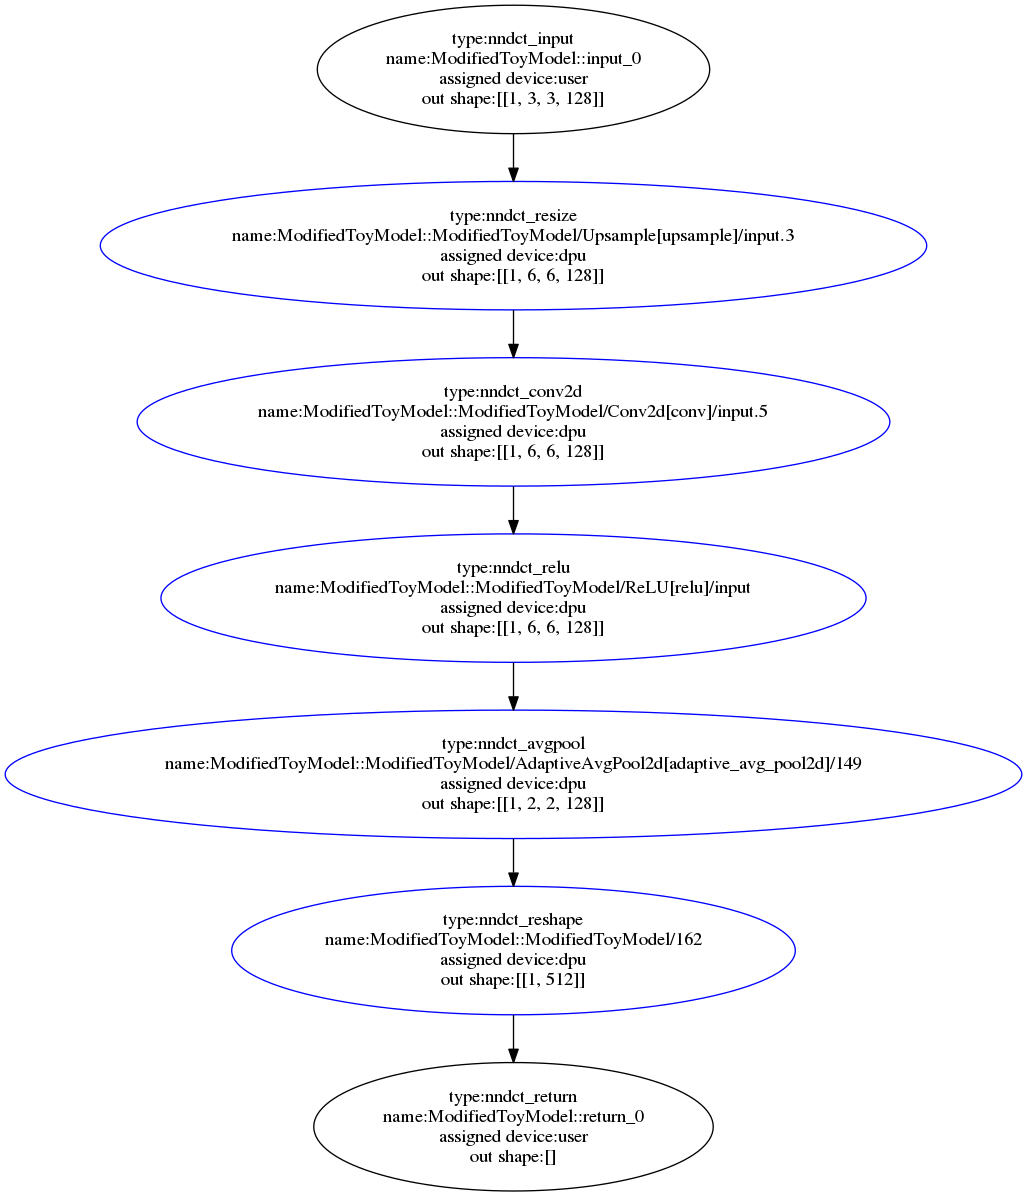

In [9]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCAHX8L_ISA0_SP.png')

##### Inspection result anaysis:
Finally, under the guidance of the inspector, the entire ToyModel can be deployed on the DPU.